In [1]:
! pip install datasets
! pip install transformers

In [2]:
from datasets import load_dataset
import csv
import json
from transformers import AutoProcessor
import os
from torch.utils.data import Dataset,DataLoader
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from datasets import load_dataset
from IPython.display import display
from PIL import Image
import numpy as np
from transformers import AutoModelForCausalLM
import torch
import time
torch.cuda.empty_cache()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# path to the folder containing the images
root = "refined_data/"

train_dataset = load_dataset("imagefolder", data_dir=root+'train/', split="train")
print(train_dataset)
val_dataset = load_dataset("imagefolder", data_dir=root+'validation/', split="train")
print(val_dataset)

Resolving data files: 100%|██████████| 1736/1736 [00:00<00:00, 16830.58it/s]
Using custom data configuration default-f8ab55c77f400673
Found cached dataset imagefolder (/root/.cache/huggingface/datasets/imagefolder/default-f8ab55c77f400673/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


Dataset({
    features: ['image', 'id', 'text'],
    num_rows: 1735
})


Resolving data files: 100%|██████████| 223/223 [00:00<00:00, 226966.71it/s]
Using custom data configuration default-c5f9eabd27a27135
Found cached dataset imagefolder (/root/.cache/huggingface/datasets/imagefolder/default-c5f9eabd27a27135/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


Dataset({
    features: ['image', 'id', 'text'],
    num_rows: 222
})


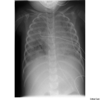

In [7]:
"""Let's take a look at one training example:"""

tr_example = train_dataset[0]
tr_image = tr_example["image"]
display(tr_image.resize((224,224)))


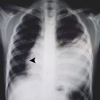

In [8]:
"""Let's take a look at one validation example:"""
val_example = val_dataset[0]
val_image = val_example["image"]
display(val_image.resize((224,224)))

In [9]:
"""Let's check its corresponding caption:"""

print(tr_example["text"])



the girl: chest x-ray film, done after admission to hospital, showing increasing bilateral infiltrations of the lung, done after admission.


In [10]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding



In [11]:
processor = AutoProcessor.from_pretrained('microsoft/git-base-textcaps')

In [12]:
train_ds = ImageCaptioningDataset(train_dataset, processor)
val_ds =ImageCaptioningDataset(val_dataset, processor)

In [13]:
"""## Create PyTorch DataLoader"""
tr_dataloaders = DataLoader(train_ds, shuffle=True, batch_size=8)
val_dataloaders = DataLoader(train_ds, shuffle=True, batch_size=8)

In [14]:
tr_batch = next(iter(tr_dataloaders))
for k,v in tr_batch.items():
  print(k,v.shape)

val_batch = next(iter(val_dataloaders))
for k,v in val_batch.items():
  print(k,v.shape)


input_ids torch.Size([8, 512])
attention_mask torch.Size([8, 512])
pixel_values torch.Size([8, 3, 224, 224])
input_ids torch.Size([8, 512])
attention_mask torch.Size([8, 512])
pixel_values torch.Size([8, 3, 224, 224])


In [15]:
"""denormalize" the pixel values to get back an image:"""


MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

#train
tr_unnormalized_image = (tr_batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
tr_unnormalized_image = (tr_unnormalized_image * 255).astype(np.uint8)
tr_unnormalized_image = np.moveaxis(tr_unnormalized_image, 0, -1)
print(Image.fromarray(tr_unnormalized_image))


<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2A00617400>


In [16]:
# validation
val_unnormalized_image = (tr_batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
val_unnormalized_image = (val_unnormalized_image * 255).astype(np.uint8)
val_unnormalized_image = np.moveaxis(val_unnormalized_image, 0, -1)
print(Image.fromarray(val_unnormalized_image))

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2A021AEC10>


In [17]:
## Define model

model = AutoModelForCausalLM.from_pretrained("microsoft/git-large-textcaps")


In [18]:
"""Dummy forward pass

It's always good to check the initial training loss on a batch. See also the blog above.
"""
# # Init training loss
outputs = model(input_ids=tr_batch["input_ids"],
                attention_mask=tr_batch["attention_mask"],
                pixel_values=tr_batch["pixel_values"],
                labels=tr_batch["input_ids"])
print('init train loss',outputs.loss)

# Init validation loss
#outputs = model(input_ids=val_batch["input_ids"],
 #               attention_mask=val_batch["attention_mask"],
  #              pixel_values=val_batch["pixel_values"],
   #             labels=val_batch["input_ids"])
#print('init val loss',outputs.loss)

init train loss tensor(12.1808, grad_fn=<NllLossBackward>)


In [19]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device)
since = time.time
run_loss = 0.0
valrun_loss = 0.0

cuda


In [20]:
for epoch in range(10):
    print("Epoch:", epoch)
    for phase in ['train','val']:
        if phase == 'train':
            model.train()
            for idx,tr_batch in enumerate(tr_dataloaders):
                input_ids = tr_batch.pop("input_ids").to(device)
                pixel_values = tr_batch.pop("pixel_values").to(device)
        
                optimizer.zero_grad()
            
                with torch.set_grad_enabled(True):
                    outputs = model(input_ids=input_ids,
                                            pixel_values=pixel_values,
                                                         labels=input_ids)
          
                    loss = outputs.loss
           
                    loss.backward()
                    optimizer.step()
                    
                run_loss += loss.item()*pixel_values.size(0)
            torch.save(model,'git_finetune_2.pth')
        else:
            model.eval()
            for idx,val_batch in enumerate(val_dataloaders):
                input_ids = val_batch.pop("input_ids").to(device)
                pixel_values = val_batch.pop("pixel_values").to(device)
        
                optimizer.zero_grad()
                outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
                loss = outputs.loss
                
            valrun_loss += loss.item()*pixel_values.size(0)
        
        tr_loss = run_loss/len(tr_dataloaders.dataset)
        val_loss = valrun_loss/len(val_dataloaders.dataset)
        
time_elapsed = time.time() - since
    
print(time_elapsed)    
 #   print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))  
        
print('TrainingLoss: {:.4f} ValidationLoss: {:.4f}'.format(tr_loss, val_loss))



Epoch: 0


RuntimeError: CUDA out of memory. Tried to allocate 476.00 MiB (GPU 0; 15.74 GiB total capacity; 13.38 GiB already allocated; 89.56 MiB free; 14.17 GiB reserved in total by PyTorch)